# Table of Contents
1. [Introduction](#intro)


2. [Exploratory Data Analysis](#EDA)

    2.1 [Data Quality Report](#DQR)
    
    2.2 [Visualization](#visualization)
    
     
3. [Data Cleaning](#datacleaning)


4. [Modeling](#modeling)

    4.1[Random Forest](rf)
    
    4.2[Logistic Regression](#lr)
    
    4.3[XGBoost](#xgboost)
    
    
5. [Conclusion](#conclusion)
    

<a id='intro'></a>

## Introduction

This is a data set of credit card transaction. There are ten columns and 96753 rows. Each row is a independent credit card transaction record. The dataset provides with the merchant information(Merchnum, Merch description, Merch state, Merch zip), transaction information(date, amount). The column of Fraud is the target dependent variable. My goal is to create a fraud detection system(model) using these provided features.

<a id='EDA'></a>

## Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import statsmodels.api as sm
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

/anaconda3/envs/python3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
mycolor = ["#a50026","#d73027","#f46d43","#fdae61","#fee08b","#d9ef8b","#a6d96a","#66bd63","#1a9850","#006837"]
palette  = sns.color_palette(mycolor)
sns.set_palette(palette)

In [4]:
transac = pd.read_excel('card transactions.xlsx',parse_dates=True, dtype = {'Merch zip': np.str} )

/anaconda3/envs/python3/lib/python3.7/site-packages/pandas/io/excel.py:520: UserWarning: The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.
  warn("The 'parse_dates=True' keyword of read_excel was provided"


In [5]:
transac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
Recnum               96753 non-null int64
Cardnum              96753 non-null int64
Date                 96753 non-null datetime64[ns]
Merchnum             93378 non-null object
Merch description    96753 non-null object
Merch state          95558 non-null object
Merch zip            96753 non-null object
Transtype            96753 non-null object
Amount               96753 non-null float64
Fraud                96753 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 7.4+ MB


In [6]:
transac.describe()

,Recnum,Cardnum,Amount,Fraud
count,96753.000000,9.675300e+04,9.675300e+04,96753.000000
mean,48377.000000,5.142202e+09,4.278857e+02,0.010945
std,27930.329635,5.567084e+04,1.000614e+04,0.104047
min,1.000000,5.142110e+09,1.000000e-02,0.000000
25%,24189.000000,5.142152e+09,3.348000e+01,0.000000
50%,48377.000000,5.142196e+09,1.379800e+02,0.000000
75%,72565.000000,5.142246e+09,4.282000e+02,0.000000
max,96753.000000,5.142847e+09,3.102046e+06,1.000000


In [7]:
transac.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0


<a id='DQR'></a>

#### Data Quality Report

<a id='summary'></a>

##### Summary Information

We can see from the `transac.info()` command that there are 96753 entreis and 10 columns. Some of thee variables have missing values(Merchnum, Merch state, Merch zip) that we need to make up before we move on. 

Also, some of the variables should be characters but are defined as numeric variables mistakenly when reading the data, so I have to change them into categorical variabels first.

In [8]:
type_change_column = ['Recnum','Cardnum','Fraud']

for col in type_change_column:
    transac[col] = transac[col].apply(str)

transac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
Recnum               96753 non-null object
Cardnum              96753 non-null object
Date                 96753 non-null datetime64[ns]
Merchnum             93378 non-null object
Merch description    96753 non-null object
Merch state          95558 non-null object
Merch zip            96753 non-null object
Transtype            96753 non-null object
Amount               96753 non-null float64
Fraud                96753 non-null object
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 7.4+ MB


In [9]:
transac.set_index('Recnum')

,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
Recnum,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0
3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
6,5142149874,2010-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118,P,3.67,0
7,5142189277,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
8,5142191182,2010-01-01,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429,P,230.32,0
9,5142258629,2010-01-01,602608969534,FISHER SCI ATL,GA,30091,P,62.11,0


In [10]:
print("min date: %s, max date %s" %(transac['Date'].min().date(), transac['Date'].max().date()))   
      

min date: 2010-01-01, max date 2010-12-31


The transaction date range is from Feb28, 2010 to Dec31, 2010.

In [11]:
transac.describe()

,Amount
count,9.675300e+04
mean,4.278857e+02
std,1.000614e+04
min,1.000000e-02
25%,3.348000e+01
50%,1.379800e+02
75%,4.282000e+02
max,3.102046e+06


<a id='recnum'></a>

###### Recnum

I have transformed this column into index of the transac dataframe since the recnum column just gives a number of order to all the transactions and doesn't provide us with any useful information for further modeling.

It has no missing value.

<a id='cardnum'></a>

###### Cardnum

In [12]:
transac.Cardnum.value_counts().describe()

count    1645.000000
mean       58.816413
std        84.571255
min         1.000000
25%        10.000000
50%        30.000000
75%        73.000000
max      1192.000000
Name: Cardnum, dtype: float64

'Cardnum' column records the number of the card that are used in this specific transaction. Each card number represents one card.

There is no missing value in this column.

The transaction frequency during 2010 for each card is quite diversed. We can see from the description of the value counts that the most frequently transacted card are used over 1000 times in 2010. While the majority of the cards are used less than 100 times during a year. 

<a id='date'></a>

###### Date

Date has no missing values.

Since date may give us other information of fraud and non fraud transaction patterns(day of week, month, etc) I would like to explore more about this column.


In [13]:
transac['Date'].apply(lambda x:x.weekday()).value_counts()
transac['Month']= transac['Date'].apply(lambda x:x.month)
transac['Day_of_week'] = transac['Date'].apply(lambda x:x.weekday())
transac['Day_of_year'] = transac['Date'].apply(lambda x:x.dayofyear)

In [14]:

transac['Day_of_week'] = ['Monday' if weekday==0 else 'Tuesday' if weekday ==1 else 'Wednesday' if weekday ==2 else 'Thursday' if weekday ==3 else 'Friday' if weekday ==4  else 'Saturday' if weekday ==5 else 'Sunday' for weekday in list(transac['Day_of_week'])]



<a id='merchnum'></a>

###### Merchnum

In [15]:
transac['Merchnum'].isna().sum()

3375

There are 3375 missing values in this columns. These missing values can't be imputed using indecators from other columns. Even though two transactions have the same merchant descriptions, it doesn't necessarily mean that they are from the same merchant.

<a id='merchdesc'></a>

#### Merch Description

In [16]:
transac['Merch description'].isna().sum()

0

There are no missing values in Merch Description column.

In [17]:
transac['Merch description'].value_counts().head(10)

GSA-FSS-ADV               1688
SIGMA-ALDRICH             1635
STAPLES #941              1174
FISHER SCI ATL            1093
MWI*MICRO WAREHOUSE        958
CDW*GOVERNMENT INC         872
DELL MARKETING L.P.        816
FISHER SCI CHI             783
AMAZON.COM  *SUPERSTOR     750
OFFICE DEPOT #1082         748
Name: Merch description, dtype: int64

<a id='merchstate'></a>

###### Merch State

In [18]:
transac['Merch state'].isna().sum()

1195

There are 1195 missing values in this column. This can be possibly imputed or inferenced from the Merch zip column.

<a id='merchzip'></a>

###### Merch zip

In [19]:
transac['Merch zip'].isna().sum()

0

In [20]:
sum(transac['Merch zip']== 'nan')

4656

Although there is no NaN value in this column, since I have transformed this column into a character, so the original nan value has also been transformed to strings. As we can see, there should be 4656 misssing values in this column.

<a id='transtype'></a>

###### Transtype

The column 'Transtype' stands for 'transaction type'.

In [21]:
transac['Transtype'].isna().sum()

0

In [22]:
sum(transac['Transtype']== 'nan')

0

Transtype column has 0 missing values. Category and frequency of Transtype:

In [23]:
transac['Transtype'].value_counts()

P    96398
A      181
D      173
Y        1
Name: Transtype, dtype: int64

The most frequent transaction type is P. But there is no clue provided by the professor what the four character strands for.

I searched online about [transaction types](https://www.paypalobjects.com/en_US/vhelp/paypalmanager_help/transaction_type_codes.htm). 

P = Prenote, A = Authorization, D = Delayed Capture.

The reference website doesn't have a label of 'Y' type transaction.

Since there is only one transaction is labelled 'Y' in this dataset and it's not a fraud transaction. I decide to ignore this type of transaction for now.

In [24]:
transac.loc[transac['Transtype']=='Y']

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Month,Day_of_week,Day_of_year
66908,66909,5142212486,2010-08-24,NaN,PAYMENT ADJUSTMENT,NaN,nan,Y,85.21,0,8,Tuesday,236


<a id='amount'></a>


###### Amount

Amount is the dollar spent amount of this transaction. There is no missing values in this column.

In [25]:
transac['Amount'].isna().sum()

0

In [26]:
transac['Amount'].describe()

count    9.675300e+04
mean     4.278857e+02
std      1.000614e+04
min      1.000000e-02
25%      3.348000e+01
50%      1.379800e+02
75%      4.282000e+02
max      3.102046e+06
Name: Amount, dtype: float64

Most transaction amount is below $5000. There are only 314 transactions out of 96753 are over $5000.

<a id='fraud'></a>

###### Fraud

There is no missing values in this column. Fraud would be the target variable in the modeling part.

There are only 1059 fraud transations out of 96753 transactions, i.e., 1.1%.

In [27]:
pd.DataFrame(transac['Fraud'].value_counts())

,Fraud
0,95694
1,1059


<a id='visualization'></a>

#### Visualization

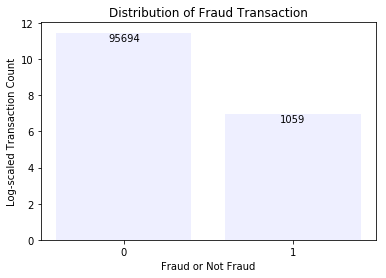

In [28]:
# Since there is only 1% of the transactions are fraud transactions, 
# the fraud transaction on the bar plot with the y axis of transaction count would be very short compared to not fraud transactions.

# So I use log-scaled transaction counts here and add the actual number of the 
# transactions in case readers are mislead by the height of the bar plot.
fraud_counts = pd.DataFrame(transac['Fraud'].value_counts())

plt.bar(fraud_counts.index, np.log(fraud_counts.Fraud), label = fraud_counts.Fraud, color = '#eeefff')
plt.xlabel('Fraud or Not Fraud')
plt.ylabel('Log-scaled Transaction Count')
plt.text(0, 11, fraud_counts.iloc[0]['Fraud'],horizontalalignment='center')
plt.text(1, 6.5, fraud_counts.iloc[1]['Fraud'],horizontalalignment='center')
plt.title('Distribution of Fraud Transaction')
plt.show()

In [29]:
bymonth_transac = transac.groupby(["Month",'Fraud'])

In [30]:
amount_dist_month_fraud = bymonth_transac.sum()
amount_dist_month_fraud.head()

Amount  Day_of_year
Month Fraud                         
1     0      2403030.13       110189
      1         9328.09          317
2     0      2744348.12       348052
      1         9613.17          767
3     0      3296710.10       705942

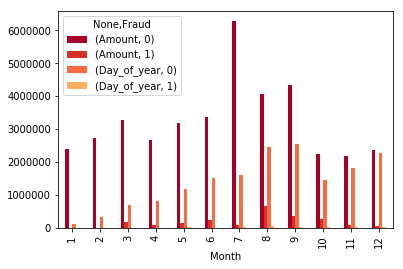

In [31]:
amount_dist_month_fraud.unstack().plot(kind= 'bar' , stacked= False)


In [32]:
byday_transac = transac[['Recnum','Day_of_year','Fraud']].groupby(["Day_of_year",'Fraud']).count()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f3f46a0>,
      dtype=object)

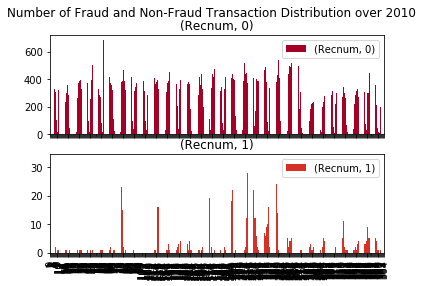

In [33]:
byday_transac.unstack().plot(kind= 'bar',stacked = False, legend = True, subplots= True, use_index=False, title ='Number of Fraud and Non-Fraud Transaction Distribution over 2010' )

In [34]:
transac['Merch_state_na']= transac['Merch state'].isna()
transac['Merch_zip_na']= transac['Merch zip']== 'nan'
transac['Merchnum_na']= transac['Merchnum'].isna()

transac['Merch_zip_na'].sum()

4656

In [35]:
def missing_matters(column_name):
    df  = transac.groupby([column_name,'Fraud']).count()
    df2 = pd.DataFrame(pd.concat([df['Recnum'].loc[False] / df['Recnum'].loc[False].sum() *100 ,df['Recnum'].loc[True]/ df['Recnum'].loc[True].sum()*100]))
    df2['missing'] = ['not_na','not_na','na', 'na']
    df2['Fraud'] = [0,1,0,1]
    df2.set_index(['missing','Fraud'], inplace =True)
    ax = df2.unstack().plot(kind='bar', title = 'Fraud Transaction Proportion when %s is True and False' % column_name)


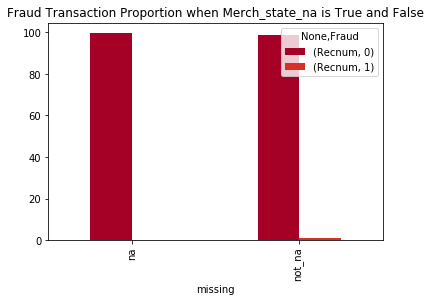

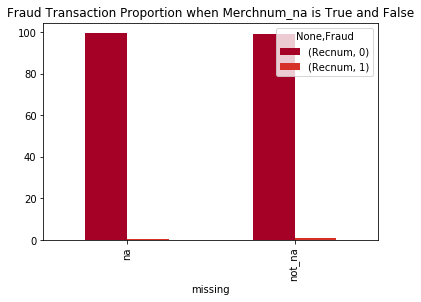

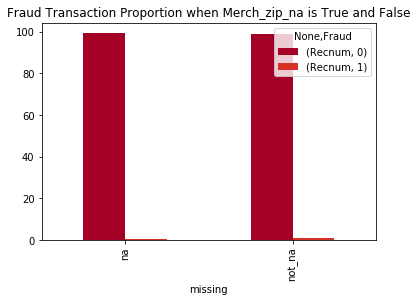

In [36]:
ax1 = missing_matters('Merch_state_na')
ax2 = missing_matters('Merchnum_na')
ax3 = missing_matters('Merch_zip_na')

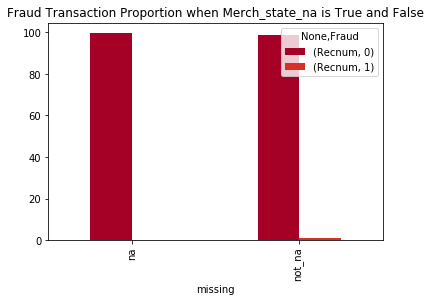

In [37]:
missing_matters('Merch_state_na')

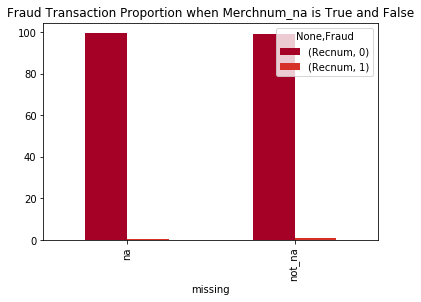

In [38]:
missing_matters('Merchnum_na')

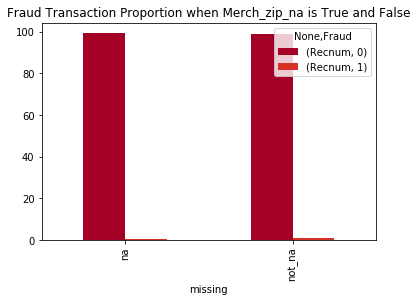

In [39]:
missing_matters('Merch_zip_na')

Recnum
missing Fraud           
not_na  0      98.879822
        1       1.120178
na      0      99.614815
        1       0.385185

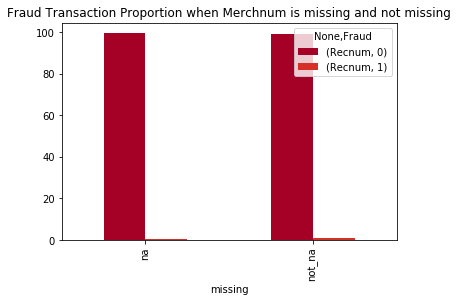

In [40]:
df  = transac.groupby(['Merchnum_na','Fraud']).count()
df.head()
df2 = pd.DataFrame(pd.concat([df['Recnum'].loc[False] / df['Recnum'].loc[False].sum() *100 ,df['Recnum'].loc[True]/ df['Recnum'].loc[True].sum()*100]))

df2['missing'] = ['not_na','not_na','na', 'na']
df2['Fraud'] = [0,1,0,1]

df2.set_index(['missing','Fraud'], inplace =True)

ax = df2.unstack().plot(kind='bar', title = 'Fraud Transaction Proportion when %s is missing and not missing' % 'Merchnum')

df2

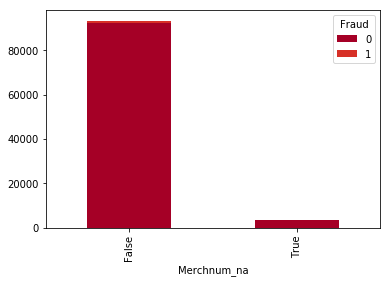

In [41]:
df.unstack().plot(kind='bar', stacked= True, y='Recnum')

We can see the average spending amount of fraud transactions and non-fraud transactions have a huge difference.

Fraud transaction will spend a lot more than average normal spendings.

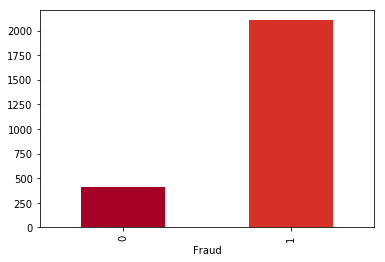

In [42]:
transac.groupby('Fraud').mean()['Amount'].plot(kind='bar')

In [43]:
transac.groupby(['Fraud','Month']).count().head()

Recnum  Cardnum  Date  Merchnum  Merch description  Merch state  \
Fraud Month                                                                    
0     1        6788     6788  6788      6504               6788         6691   
      2        7739     7739  7739      7472               7739         7695   
      3        9367     9367  9367      8986               9367         9224   
      4        7662     7662  7662      7383               7662         7574   
      5        8836     8836  8836      8485               8836         8730   

             Merch zip  Transtype  Amount  Day_of_week  Day_of_year  \
Fraud Month                                                           
0     1           6788       6788    6788         6788         6788   
      2           7739       7739    7739         7739         7739   
      3           9367       9367    9367         9367         9367   
      4           7662       7662    7662         7662         7662   
      5           8836       8836    8836         8836         8836   

             Merch_state_na  Merch_zip_na  Merchnum_na  
Fraud Month                                             
0     1                6788          6788         6788  
      2                7739          7739         7739  
      3                9367          9367         9367  
      4                7662          7662         7662  
      5                8836          8836         8836

The plots below showed us that August seems to have the most transaction during the whole year, regardless of whether it's fraud or not.  But in fraud transactions, August seems to be more more outstanding than it in non-fraud transactions.

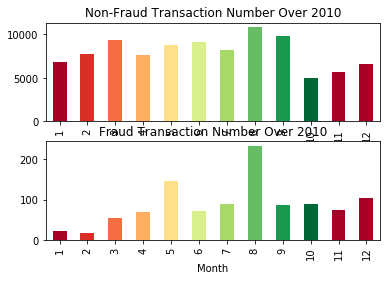

In [44]:
f1 = plt.figure(1)
plt.subplot(211)


transac.groupby(['Fraud','Month']).count().loc['0']['Recnum'].plot(kind='bar',title = 'Non-Fraud Transaction Number Over 2010')
plt.subplot(212)

transac.groupby(['Fraud','Month']).count().loc['1']['Recnum'].plot(kind='bar',title = 'Fraud Transaction Number Over 2010')


Fraud transactions seem to happen more frequently in Thursday, considering the non-fraud transaction number happened in Thursday. But Saturday, Sunday, Wednesday seem to have larger-value fraud transaction than other days of week.

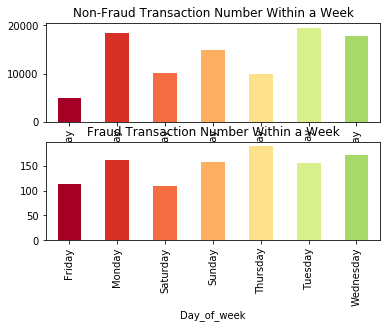

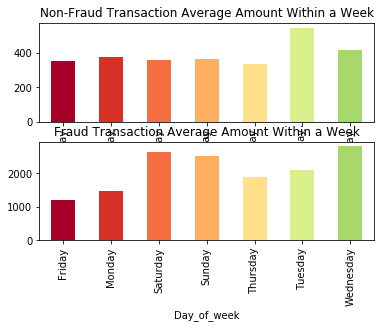

In [45]:
f1 = plt.figure(1)
plt.subplot(211)


transac.groupby(['Fraud','Day_of_week']).count().loc['0']['Recnum'].plot(kind='bar',title = 'Non-Fraud Transaction Number Within a Week')
plt.subplot(212)

transac.groupby(['Fraud','Day_of_week']).count().loc['1']['Recnum'].plot(kind='bar',title = 'Fraud Transaction Number Within a Week')


f2 = plt.figure(2)
plt.subplot(211)

transac.groupby(['Fraud','Day_of_week']).mean().loc['0']['Amount'].plot(kind='bar',title = 'Non-Fraud Transaction Average Amount Within a Week')
plt.subplot(212)

transac.groupby(['Fraud','Day_of_week']).mean().loc['1']['Amount'].plot(kind='bar',title = 'Fraud Transaction Average Amount Within a Week')


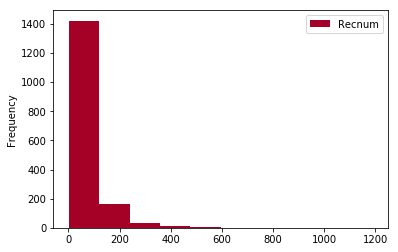

In [46]:
card_usage_frequency = transac[['Recnum','Cardnum']].groupby(['Cardnum']).count()

card_usage_frequency.plot(kind='hist',legend=True)

In [47]:
transac['Fraud_new']  = [0 if val == '0' else 1 for val in transac['Fraud']]

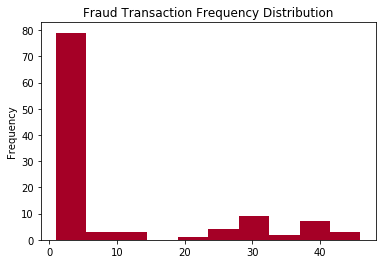

In [48]:
transac.groupby(['Cardnum']).sum()['Fraud_new'].loc[transac.groupby(['Cardnum']).sum()['Fraud_new']>0].plot(kind='hist',title = 'Fraud Transaction Frequency Distribution')


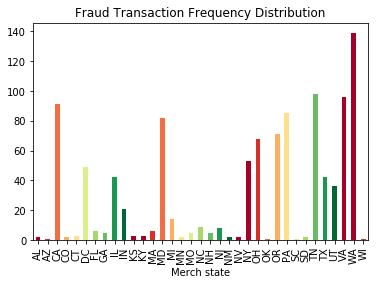

In [49]:
transac.groupby(['Merch state']).sum()['Fraud_new'].loc[transac.groupby(['Merch state']).sum()['Fraud_new']>0].plot(kind='bar',title = 'Fraud Transaction Frequency Distribution')


<a id='datacleaning'></a>

## Data Cleaning

##### Filling Up Missing Data

For those transactions whose Merch zip is missing but Merch state is still available, we can use the `Merch zip` to get the according state name.

To use uszipccode 0.1.2, you may want to install it in the Terminal first:

pip install uszipcode==0.1.2

In [50]:
from pprint import pprint
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()

In [51]:
transac['Merch state_byzip'] = list(map(lambda x: search.by_zipcode(x).State, transac['Merch zip']))

In [52]:
state_canbe_filled_list = list(transac[transac['Merch_state_na'] == True][transac['Merch_zip_na'] == False].index)

/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [53]:
for i in state_canbe_filled_list:
    transac['Merch state'][i] = transac['Merch state_byzip'][i]

/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


For those transactions whose Merchant zipcode is missing but Merchant state is not missing, I am going to replace the missing zipcode with the most frequent zipcode in that state in terms of number of transactions.

In [54]:
transac['Merch zip'] = [ np.nan if val=='nan' else val for val in transac['Merch zip']]

In [55]:
Most_frequent_zip = pd.DataFrame(transac.groupby(['Merch state','Merch zip']).count()['Recnum'].groupby(level=0, group_keys = False).nlargest(1))

# Most_frequent_zip.dropna(axis = 0, inplace = True)

Most_frequent_zip.reset_index(level=0, inplace = True)

Most_frequent_zip.reset_index(level=0, inplace = True)

In [56]:
Most_frequent_zip.loc[len(Most_frequent_zip)]=[np.nan,np.nan,np.nan] 

In [57]:
Most_frequent_zip.append({'Merch zip' : np.nan , 'Merch state' : np.nan , 'Recnum': np.nan} , ignore_index=True)

,Merch zip,Merch state,Recnum
0,99501,AK,56.0
1,35801,AL,78.0
2,72764,AR,9.0
3,85285,AZ,109.0
4,92656,CA,552.0
5,80202,CO,260.0
6,06907,CT,126.0
7,20005,DC,535.0
8,19713,DE,25.0
9,33716,FL,241.0


In [58]:
transac_merged = pd.merge(transac,Most_frequent_zip, on='Merch state', how= 'left')

In [59]:
transac_merged.rename(columns = {'Merch zip_y':'Most_freq_zip_by_state'}, inplace = True)

In [60]:
transac_merged.rename(columns = {'Merch zip_x':'Merch zip'}, inplace = True)

In [61]:
zip_canbe_filled_list = list(transac_merged[transac_merged['Merch_zip_na'] == True][transac['Merch_state_na'] == False].index)

/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [62]:
for i in zip_canbe_filled_list:
    transac_merged['Merch zip'][i] = transac_merged['Most_freq_zip_by_state'][i]

/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
Merchnum_0_missing_list = list(transac_merged[transac_merged['Merchnum'].isna()| (transac_merged['Merchnum'] =='0')].index)

In [64]:
for i in Merchnum_0_missing_list:
    transac_merged['Merchnum'][i] = np.nan

/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<a id='modeling'></a>

#### Modeling and Model Evaluation

In [65]:
transac_merged['Fraud'] = [0 if val =='0' else 1 for val in transac_merged['Fraud']]

In [66]:
model_variables = ['Merchnum', 'Merch state','Merch zip', 'Transtype', 'Amount','Fraud']

In [67]:
data_relevant = transac_merged[model_variables]

Get dummy variables to put them into the model.

In [68]:
data_relevant_encoded = pd.get_dummies(data_relevant)

Split the data into training set and validation set.

In [70]:
training_features, test_features, \
training_target, test_target, = train_test_split(data_relevant_encoded.drop('Fraud',axis=1, inplace=False),
data_relevant_encoded['Fraud'],test_size = 0.3,random_state = 12)

In [71]:
x_train, x_val , y_train, y_val = train_test_split(training_features, training_target, test_size = .3, random_state=12)

Since there are too little fraud transactions, oversampling is necessary to get better model performance.

In [72]:
sm = SMOTE(random_state=12, ratio = 1.0)

In [73]:
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

/anaconda3/envs/python3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


<a id='rf'></a>

##### Random Forest Classification

I defined two functions to get the model accuracy and the ROC curve for model comparison.

In [74]:
def get_accuracy(model, model_name):
    y_pred = model.predict(x_val)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_val, predictions)
    print("The accuracy of" + model_name +' model: %.2f%%' % (accuracy * 100.0))

In [75]:
def get_roc_curve(m,model_name):
    roc_auc = roc_auc_score(y_val, m.predict(x_val))
    fpr, tpr, thresholds = roc_curve(y_val, m.predict_proba(x_val)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label= model_name +' (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig(model_name)
    plt.show()

In [76]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [77]:
print('Validation Results')
print(clf_rf.score(x_val, y_val))
#print(recall_score(y_val, clf_rf.predict(x_val)))
print('\nTest Results')
print(clf_rf.score(test_features, test_target))
#print(recall_score(test_target, clf_rf.predict(test_features)))

Validation Results
0.991338156405335

Test Results
0.9915248397988011


In [78]:
get_accuracy(clf_rf, "Random Forest Classification")

The accuracy ofRandom Forest Classification model: 99.13%


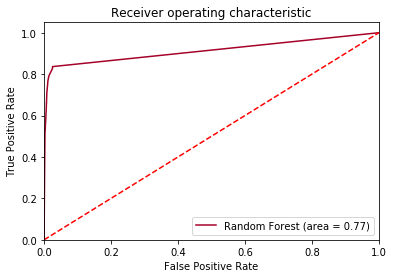

In [79]:
rf_roc_auc = roc_auc_score(y_val, clf_rf.predict(x_val))
fpr, tpr, thresholds = roc_curve(y_val, clf_rf.predict_proba(x_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

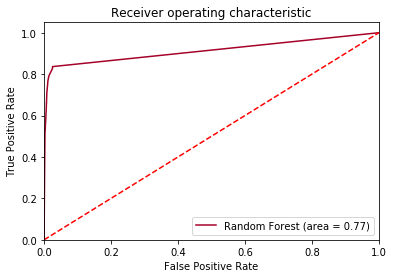

In [80]:
get_roc_curve(clf_rf,'Random Forest')

<a id='lr'></a>

##### Logistic Regression

In [81]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [82]:
logreg = LogisticRegression()

In [83]:
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [84]:
y_pred = logreg.predict(x_val)

In [85]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_val, y_val)))

Accuracy of logistic regression classifier on test set: 0.99


In [86]:
get_accuracy(logreg, "Logistic Regression")

The accuracy ofLogistic Regression model: 99.14%


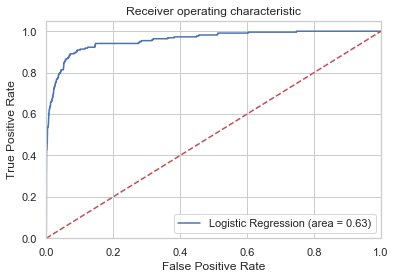

In [87]:
logit_roc_auc = roc_auc_score(y_val, logreg.predict(x_val))
fpr, tpr, thresholds = roc_curve(y_val, logreg.predict_proba(x_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

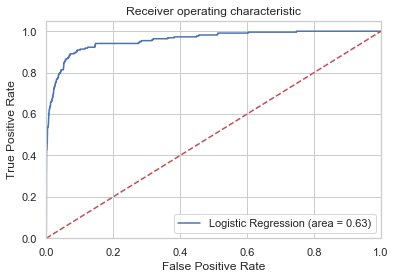

In [88]:
get_roc_curve(logreg,'Logistic Regression')

<a id='xgboost'></a>

##### XGBoost Model

In [89]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [90]:
# make predictions for test data
y_pred = xgb.predict(x_val)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/anaconda3/envs/python3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 99.18%


In [91]:
get_accuracy(xgb, "XGBoost")

/anaconda3/envs/python3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accuracy ofXGBoost model: 99.18%


/anaconda3/envs/python3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


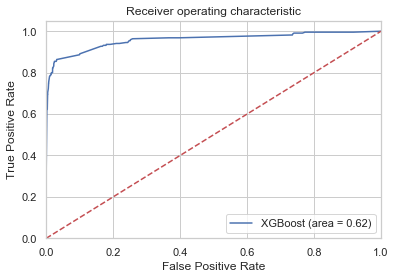

In [92]:
xgboost_roc_auc = roc_auc_score(y_val, xgb.predict(x_val))
fpr, tpr, thresholds = roc_curve(y_val, xgb.predict_proba(x_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % xgboost_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')
plt.show()

/anaconda3/envs/python3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


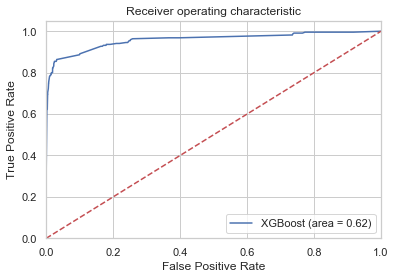

In [93]:
get_roc_curve(xgb,'XGBoost')

<a id='conclusion'></a>

## Conclusion

From accuracy, we can't tell which model is better because there are not many transactions in this dataset. The false negative rate might be high. But since logistic regession model gets larger area under the ROC curve, we can decide on logistic regression model to do the further prediction and identification.

This project is rough and incomprehensive. Better models could be built by parameter tunings and building more variables on the basis of current dataset, if more time is provided.

I am graduating from my Business Analytics program today. It's great that I took your class as the mere one that I was taking during the last quarter of my master's study at UCSD. Your detailed and organized lecture notes just help me learn python more easily. I really appreciate your time and effort in this class. If there is a need of data mining in your research team, please feel free to contact me at Bihan.Zhu@rady.ucsd.edu. I would be more than happy to help.

Thank you again and have a wonderful winter break!